<a href="https://colab.research.google.com/github/threegenie/knn_project/blob/main/bbc_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import os, sys
import numpy as np
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/BBCarticles_csv.csv',encoding= 'unicode_escape')
df.head()

Mounted at /content/drive


,Summary,Text
0,TimeWarner said fourth quarter sales rose 2% t...,Ad sales boost Time Warner profit\n\nQuarterly...
1,The dollar has hit its highest level against t...,Dollar gains on Greenspan speech\n\nThe dollar...
2,Yukos' owner Menatep Group says it will ask Ro...,Yukos unit buyer faces loan claim\n\nThe owner...
3,"Rod Eddington, BA's chief executive, said the ...",High fuel prices hit BA's profits\n\nBritish A...
4,Pernod has reduced the debt it took on to fund...,Pernod takeover talk lifts Domecq\n\nShares in...


#### 토큰 정제

In [3]:
!pip install squarify

In [4]:
import re
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.tokenizer import Tokenizer

In [5]:
#결측값 처리
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Summary  2225 non-null   object
 1   Text     2225 non-null   object
dtypes: object(2)
memory usage: 52.1+ KB


In [6]:
#문자를 소문자로 통일
df['Text'] = df['Text'].apply(lambda x : x.lower())
df['Text'].head(3)

0    ad sales boost time warner profit\n\nquarterly...
1    dollar gains on greenspan speech\n\nthe dollar...
2    yukos unit buyer faces loan claim\n\nthe owner...
Name: Text, dtype: object

In [7]:
#줄바꿈 문자 정리
df['Text'] = df['Text'].str.replace('\n',' ')
df['Text'].head(3)

0    ad sales boost time warner profit  quarterly p...
1    dollar gains on greenspan speech  the dollar h...
2    yukos unit buyer faces loan claim  the owners ...
Name: Text, dtype: object

In [8]:
#알파벳, 숫자만 받을 수 있도록 함수 작성(text):

regex = r"[^a-zA-Z0-9 ]"
subst = ""

def tokenize(text):

    # 정규식 적용
    tokens = re.sub(regex, subst, text)

    # split
    tokens = tokens.split()
    
    return tokens

df['Tokens'] = df['Text'].apply(tokenize)

In [9]:
#기본 불용어 불러오기
nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)
print(nlp.Defaults.stop_words)

{'becomes', 'only', 'towards', 'twenty', 'be', 'often', 'too', 'perhaps', 'during', '’m', 'about', 'make', 'through', 'would', 'until', 'front', 'do', '‘ve', 'most', 'an', 'since', 'around', 'back', 'over', 'unless', 'some', 'fifty', 'been', '’ve', 'once', 'give', 'when', 'say', '‘d', 'even', "'ll", 'hereafter', 'then', 'several', "'ve", 'because', 'bottom', 'nine', 'now', 'while', 'themselves', 'eleven', 'forty', 'although', 'he', 'seeming', 'before', 'sometime', 'own', 'onto', 'done', 'again', 'quite', 'last', 'beforehand', 'latter', 'become', 'latterly', 'one', 'not', 'so', 'many', "'d", 'ever', 'what', 'full', 'mine', 'we', 'down', 'she', 'that', 're', 'seems', 'whole', 'but', "'m", 'after', 'just', 'any', 'itself', 'formerly', 'as', 'to', 'anyone', 'take', 'them', 'cannot', 'third', 'thru', 'used', 'nothing', 'moreover', 'behind', 'am', 'whereas', 'has', 'ours', 'this', 'using', 'herself', 'hereby', 'thereupon', 'will', 'really', 'please', 'hereupon', 'others', 'nor', 'a', 'i', 't

In [10]:
#불용어 추가하기
st_words = nlp.Defaults.stop_words.union(['this', 'i', 'it', 'is', 'in', 'and', 'a', 'the', 'but', 'to', "it's", "i'm",'it.',' ',
                                          'said','-','mr','new','said.','"i','told','"the','uk','best','year','time',
                                          'like','"we','number','bbc','said:','years'])

In [11]:
#불용어 처리 + lemmatization
tokens = []

for doc in tokenizer.pipe(df['Text']):
    doc_tokens = []
    for token in doc:
        if token.text.lower() not in st_words and ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)
    
df['Tokens'] = tokens
df['Tokens'].head(3)

0    [ad, sales, boost, warner, profit, quarterly, ...
1    [dollar, gains, greenspan, speech, dollar, hit...
2    [yukos, unit, buyer, faces, loan, claim, owner...
Name: Tokens, dtype: object

#### 단어 빈도에 따라 시각화

In [12]:
from collections import Counter
word_counts = Counter()
df['Tokens'].apply(lambda x: word_counts.update(x))
word_counts.most_common(10)

[('people', 1754),
 ('government', 878),
 ('world', 792),
 ('film', 687),
 ('music', 677),
 ('set', 651),
 ('way', 626),
 ('game', 620),
 ('going', 608),
 ('labour', 591)]

In [13]:
def word_count(docs):
   
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [14]:
wc = word_count(df['Tokens'])
wc.head(5)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
1239,people,729,1754,1.0,0.003949,0.003949,0.327640
725,government,413,878,2.0,0.001977,0.005926,0.185618
525,world,471,792,3.0,0.001783,0.007710,0.211685
151,film,223,687,4.0,0.001547,0.009257,0.100225
64,music,216,677,5.0,0.001524,0.010781,0.097079


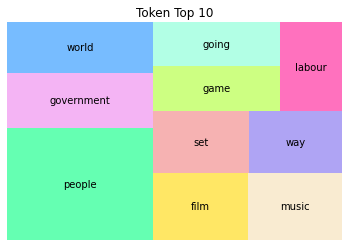

In [15]:
import squarify
import matplotlib.pyplot as plt

colors=['springgreen','violet','dodgerblue','gold','wheat','lightcoral',
        'mediumslateblue','greenyellow','aquamarine','deeppink']

wc_top5 = wc[wc['rank'] <= 10]
squarify.plot(sizes=wc_top5['percent'], label=wc_top5['word'], alpha=0.6, color=colors)
plt.axis('off')
plt.title('Token Top 10')
plt.show()

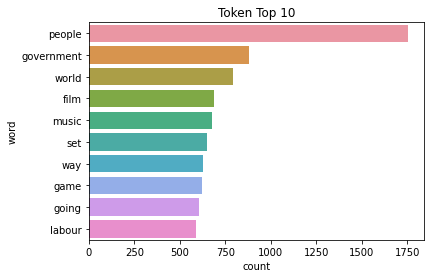

In [24]:
sns.set_palette('GnBu')
sns.barplot(x=wc['count'][:10],y=wc['word'][:10],orient='h')
plt.title('Token Top 10')
plt.show()

#### TfidVectorizer + KNN

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words= st_words, max_features=5000)
dtm = tfidf.fit_transform(df['Text'])
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

dtm.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,000,000m,05,10,100,100m,102,10bn,10th,11,110,11bn,12,120,13,14,15,150,1500m,16,17,18,19,1960s,1970,1970s,1973,1980s,1981,1983,1984,1985,1987,1989,1990s,1991,1992,1993,1994,1995,...,worried,worries,worry,worrying,worse,worst,worth,wouldn,wright,write,writer,writers,writing,written,wrong,wrote,wto,xbox,xp,yachvili,yahoo,yard,yards,yelling,yen,yes,york,yorkshire,young,younger,youngsters,youth,yuan,yugansk,yuganskneftegas,yukos,yushchenko,zealand,zero,zone
0,0.028497,0.0,0.0,0.029905,0.0,0.0,0.0,0.0,0.0,0.038506,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.065307,0.0,0.0,0.059999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095496,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.420712,0.0,0.372661,0.0,0.0,0.0,0.0
3,0.021711,0.0,0.0,0.022784,0.0,0.0,0.0,0.0,0.0,0.029337,0.0,0.0,0.0,0.0,0.032392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.052154,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [18]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True) and (token.is_alpha == True)]

In [19]:
tfidf = TfidfVectorizer(stop_words=st_words
                        ,tokenizer=tokenize
                        ,ngram_range=(1,2)
                        ,max_df=.7
                        ,min_df=3
                       )

dtm = tfidf.fit_transform(df['Text'])
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
dtm.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'good', 'm', 'tell', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,-PRON-,aaa,aaas,aaas title,aaron,abandon,abandon plan,abandonment,abate,abba,abbas,abbasi,abbasi mubanga,abbott,abc,abc network,aberdeen,abeyie,abide,abide member,ability,ability control,ability game,ability influence,ability record,able,able access,able buy,able choose,able control,able deliver,able download,able handle,able offer,able play,able sell,able spend,able start,able store,able tell,...,yulia tymoshenko,yushchenko,yusuf,z,zach,zach braff,zajec,zambia,zealand,zealand australia,zealand lion,zealand rugby,zealand summer,zealand world,zealander,zelda,zellweger,zen,zen micro,zeppelin,zero,zero tolerance,zeta,zeta jones,zhang,zheng,zidane,zimbabwe,zimbabwe burma,zinc,ziyi,ziyi zhang,zoe,zola,zombie,zombie bot,zone,zoom,zurich,zurich premiership
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
from sklearn.metrics.pairwise import cosine_similarity
distance_matrix  = cosine_similarity(dtm)
data = pd.DataFrame(distance_matrix)

In [21]:
ind = data[data[100] < 1][100].sort_values(ascending=False)[:5]
ind

10      1.000000
1885    0.404705
2141    0.404705
2036    0.258853
0       0.226501
Name: 10, dtype: float64

In [22]:
df['Text'].loc[10]

"ask jeeves tips online ad revival  ask jeeves has become the third leading online search firm this week to thank a revival in internet advertising for improving fortunes.  the firm's revenue nearly tripled in the fourth quarter of 2004, exceeding $86m (â£46m). ask jeeves, once among the best-known names on the web, is now a relatively modest player. its $17m profit for the quarter was dwarfed by the $204m announced by rival google earlier in the week. during the same quarter, yahoo earned $187m, again tipping a resurgence in online advertising.  the trend has taken hold relatively quickly. late last year, marketing company doubleclick, one of the leading providers of online advertising, warned that some or all of its business would have to be put up for sale. but on thursday, it announced that a sharp turnaround had brought about an unexpected increase in profits. neither ask jeeves nor doubleclick thrilled investors with their profit news, however. in both cases, their shares fell by

In [23]:
df['Text'].loc[1885]

'ask jeeves joins web log market  ask jeeves has bought the bloglines website to improve the way it handles content from web journals or blogs.  the bloglines site has become hugely popular as it gives users one place in which to read, search and share all the blogs they are interested in. ask jeeves said it was not planning to change bloglines but would use the 300 million articles it has archived to round out its index of the web. how much ask jeeves paid for bloglines was not revealed.  bloglines has become popular because it lets users build a list of the blogs they want to follow without having to visit each journal site individually. to do this it makes use of a technology known as really simple syndication (rss) that many blogs have adopted to let other sites know when new entries are made on their journals. the acquisition follows similar moves by other search sites. google acquired pyra labs, makers of the blogger software, in 2003. in 2004 msn introduced its own blog system a

In [25]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree') #최근접 5이웃
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [28]:
result = nn.kneighbors([dtm.iloc[1000]])
result

(array([[0.        , 1.24242228, 1.2451815 , 1.26026589, 1.26560213]]),
 array([[1000,  951, 1129, 2090, 2036]]))

In [29]:
df.iloc[result[1][0]]

,Summary,Text,Tokens
1000,UK Muslims should accept that people of Islami...,muslim police stops 'more likely' uk muslims ...,"[muslim, police, stops, 'more, likely', muslim..."
951,Britain's young black and Asian people are to ...,citizenship event for 18s touted citizenship ...,"[citizenship, event, 18s, touted, citizenship,..."
1129,"Mr Blunkett said he wanted ""to go back to a ti...",blunkett unveils policing plans people could ...,"[blunkett, unveils, policing, plans, people, g..."
2090,Web users face a plethora of choices as each c...,the year search became personal the odds are ...,"[search, personal, odds, fire, browser,, strai..."
2036,"""Blinkx users do not stop using other web sear...",search sites get closer to users search sites...,"[search, sites, closer, users, search, sites, ..."


In [30]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
print(df['Summary'].iloc[result[1][0]])

1000    UK Muslims should accept that people of Islamic appearance are more likely to be stopped and searched by police, a Home Office minister has said.Statistics showed that of the 17 people found guilty of terrorist acts in the UK since the 11 September attacks, only four of the 12 whose ethnic backgrounds were known were Muslim, he added Figures published last week showed that people from ethnic minorities were increasingly likely to be targeted by police stop and search tactics."It is not aimed at a particular community, it is not police policy to aim these powers at a particular community," he added.The minister had been saying she understood there was a perception that stop and search was aimed at one community, but that was not what was happening, the spokesman said.Last July, the police were accused of Islamophobia by Muslim groups after stop and search figures showed the numbers of Asians targeted had risen by 300% since the introduction of anti-terror laws."She is demonising

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.
